# Butterfly plots

This notebook generates the "butterfly plots" in Extended Data Fig. 1e.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import matplotlib.ticker as mtick
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
import palettable

## Load data

In [2]:
# Paths
gene_list_path = '../data/comut_genes.json' 

oncopanel_variants_path = '../data/oncopanel_all_variants_standardized.tsv' 

wes_variants_path = '../data/muts_cnas_combined.pkl' 

patient_sheet_path = '../data/participant_cohort_sheet.tsv' 
sample_sheet_path = '../data/sample_cohort_sheet.tsv' 

glass_variants_path = '../data/glass_variants_filtered_butterfly.tsv' 
glass_clinical_path = '../data/glass_clinical_surgeries_table_filtered.tsv'

# Read
gene_list = json.load(open(gene_list_path))

oncopanel_variants = pd.read_csv(oncopanel_variants_path, sep = '\t')
oncopanel_variants.replace({'GBM.ICB-3-14.637.Post.FFbank': 'GBM.ICB-3-14.233.Pre'}, inplace = True)
# op_clinical = pd.read_excel(op_clinical_path)

wes_variants = pd.read_pickle(wes_variants_path)

patient_sheet = pd.read_csv(patient_sheet_path, sep = '\t')
sample_sheet = pd.read_csv(sample_sheet_path, sep = '\t')

glass_variants = pd.read_csv(glass_variants_path, sep = '\t')
glass_clinical = pd.read_csv(glass_clinical_path, sep = '\t')

## Prepare OncoPanel variants

In [3]:
oncopanel_pts = set(sample_sheet.loc[sample_sheet['usable_oncopanel'], 'participant_id_legacy'])
len(oncopanel_pts)

155

In [4]:
oncopanel_samples_idx = sample_sheet[sample_sheet['usable_oncopanel']].groupby('participant_id_legacy')['collection_date_dfd'].idxmax()
oncopanel_samples = sample_sheet.loc[oncopanel_samples_idx, 'sample_id_legacy']

oncopanel_variants_keep = oncopanel_variants[oncopanel_variants['Sample_ID'].isin(oncopanel_samples)]
oncopanel_variants_keep = oncopanel_variants_keep.merge(sample_sheet[['sample_id_legacy', 'participant_id_legacy']], how = 'left', left_on = 'Sample_ID', right_on = 'sample_id_legacy')
oncopanel_variants_keep['sample'] = oncopanel_variants_keep['participant_id_legacy']

oncopanel_variants_keep['Patient_ID'].nunique()

151

## Prepare WES variants
The variants are already filtered to those present at the latest pre timepoint

In [5]:
wes_pts = sample_sheet.loc[sample_sheet['usable_wes'] &
                           (sample_sheet['pre_post'] == 'Pre') &
                           (~sample_sheet['participant_id_legacy'].isin(oncopanel_pts)) &
                           (sample_sheet['tumor_normal'] == 'tumor'),
                           'participant_id_legacy'].unique()

len(wes_pts)

12

In [6]:
wes_variants_keep = wes_variants[wes_variants['sample'].isin(wes_pts)]

wes_variants_keep['sample'].nunique()

12

In [7]:
wes_variants_keep["value"].value_counts()

LoH                        25
Likely Gain-of-function    12
DeepDEL                     6
Biallelic_Loss              5
GAIN                        4
FocalHighAMP                3
Missense_Mutation           2
Likely Loss-of-function     2
Gain-of-function            2
AMP                         2
In_Frame_Del                1
In_Frame_Ins                1
Name: value, dtype: int64

## Combine OncoPanel and WES clinical data and variants

In [8]:
cols_keep_variants = ['sample', 'category', 'value']
cols_keep_clinical = ['participant_id_legacy', 'ICB for Newly diagnosed']

icb_variants = pd.concat([oncopanel_variants_keep[cols_keep_variants],
                          wes_variants_keep[cols_keep_variants]],
                           ignore_index = True).rename(columns = {'category': 'Hugo_Symbol', 'value': 'Variant_Classification'})

icb_patients = sample_sheet[(sample_sheet['pre_post'] == 'Pre') & (sample_sheet['tumor_normal'] == 'tumor') & (sample_sheet['usable_oncopanel'] | sample_sheet['usable_wes'])]['participant_id_legacy'].unique()

icb_clinical = patient_sheet.loc[patient_sheet['participant_id_legacy'].isin(icb_patients), cols_keep_clinical].rename(columns = {'participant_id_legacy': 'sample', 'ICB for Newly diagnosed': 'icb_setting'})

print(icb_variants['sample'].nunique(), icb_clinical['sample'].nunique())

163 167


### Split biallelic inactivations into one mutation and one copy loss

In [9]:
icb_variants['Variant_Classification'].value_counts()

AMP                        388
DEL                        184
DeepDEL                     94
Likely Loss-of-function     59
HighAMP                     57
Gain-of-function            40
Missense                    38
LoH                         25
Biallelic_Loss              23
Likely Gain-of-function     18
Loss-of-function            13
In_Frame_Del                 6
GAIN                         4
Splice_Region                3
FocalHighAMP                 3
In_Frame_Ins                 2
Frame_Shift_Del              2
Missense_Mutation            2
Name: Variant_Classification, dtype: int64

In [10]:
biallel = icb_variants[icb_variants['Variant_Classification'] == 'Biallelic_Loss'].copy()
biallel['Variant_Classification'] = 'loss'
icb_variants.loc[icb_variants['Variant_Classification'] == 'Biallelic_Loss', 'Variant_Classification'] = 'mut'

icb_variants = pd.concat([icb_variants, biallel], ignore_index = True)
icb_variants['Variant_Classification'].value_counts()

AMP                        388
DEL                        184
DeepDEL                     94
Likely Loss-of-function     59
HighAMP                     57
Gain-of-function            40
Missense                    38
LoH                         25
mut                         23
loss                        23
Likely Gain-of-function     18
Loss-of-function            13
In_Frame_Del                 6
GAIN                         4
Splice_Region                3
FocalHighAMP                 3
In_Frame_Ins                 2
Frame_Shift_Del              2
Missense_Mutation            2
Name: Variant_Classification, dtype: int64

## Create simple harmonized variant classification
copy gain, copy loss, mutation

In [11]:
glass_variants['Variant_Classification'].value_counts()

AMP                1589
DEL                1097
DeepDEL             361
HighAMP             353
MISSENSE            325
SPLICE_SITE          65
FRAME_SHIFT_DEL      49
NONSENSE             40
IN_FRAME_DEL         19
FRAME_SHIFT_INS      14
START_CODON_SNP       2
IN_FRAME_INS          1
Name: Variant_Classification, dtype: int64

In [12]:
icb_variants['Variant_Classification'].value_counts()

AMP                        388
DEL                        184
DeepDEL                     94
Likely Loss-of-function     59
HighAMP                     57
Gain-of-function            40
Missense                    38
LoH                         25
mut                         23
loss                        23
Likely Gain-of-function     18
Loss-of-function            13
In_Frame_Del                 6
GAIN                         4
Splice_Region                3
FocalHighAMP                 3
In_Frame_Ins                 2
Frame_Shift_Del              2
Missense_Mutation            2
Name: Variant_Classification, dtype: int64

In [13]:
cna_mapping = {
    'GAIN': np.nan,
    'AMP': np.nan,
    'HighAMP': 'amp',
    'FocalHighAMP': 'amp',
    'LoH': np.nan,
    'DEL': np.nan,
    'DeepDEL': 'del',
    'loss': np.nan
}

mapping = lambda x: cna_mapping[x['Variant_Classification']] if x['Variant_Classification'] in cna_mapping.keys() else 'mut'

glass_variants['Variant_Classification_Clean'] = glass_variants.apply(mapping, axis=1)

icb_variants['Variant_Classification_Clean'] = icb_variants.apply(mapping, axis=1)

In [14]:
glass_variants[['Variant_Classification', 'Variant_Classification_Clean']].value_counts(dropna = False)

Variant_Classification  Variant_Classification_Clean
AMP                     NaN                             1589
DEL                     NaN                             1097
DeepDEL                 del                              361
HighAMP                 amp                              353
MISSENSE                mut                              325
SPLICE_SITE             mut                               65
FRAME_SHIFT_DEL         mut                               49
NONSENSE                mut                               40
IN_FRAME_DEL            mut                               19
FRAME_SHIFT_INS         mut                               14
START_CODON_SNP         mut                                2
IN_FRAME_INS            mut                                1
dtype: int64

In [15]:
icb_variants[['Variant_Classification', 'Variant_Classification_Clean']].value_counts(dropna = False)

Variant_Classification   Variant_Classification_Clean
AMP                      NaN                             388
DEL                      NaN                             184
DeepDEL                  del                              94
Likely Loss-of-function  mut                              59
HighAMP                  amp                              57
Gain-of-function         mut                              40
Missense                 mut                              38
LoH                      NaN                              25
loss                     NaN                              23
mut                      mut                              23
Likely Gain-of-function  mut                              18
Loss-of-function         mut                              13
In_Frame_Del             mut                               6
GAIN                     NaN                               4
Splice_Region            mut                               3
FocalHighAMP             amp   

In [16]:
glass_variants['category'] = glass_variants['Hugo_Symbol'] + ' ' + glass_variants['Variant_Classification_Clean']
icb_variants['category'] = icb_variants['Hugo_Symbol'] + ' ' + icb_variants['Variant_Classification_Clean']

glass_variants.head()

,Patient_ID,Sample_ID,Hugo_Symbol,Variant_Classification,Variant_Classification_Clean,category
0,GLSS-19-0266,GLSS-19-0266-TP,BRAF,MISSENSE,mut,BRAF mut
1,GLSS-19-0266,GLSS-19-0266-TP,PTPN11,MISSENSE,mut,PTPN11 mut
2,GLSS-19-0266,GLSS-19-0266-TP,NF1,NONSENSE,mut,NF1 mut
3,GLSS-19-0267,GLSS-19-0267-R1,PIK3CA,SPLICE_SITE,mut,PIK3CA mut
4,GLSS-19-0267,GLSS-19-0267-TP,PIK3CA,SPLICE_SITE,mut,PIK3CA mut


In [17]:
icb_variants[(icb_variants["Hugo_Symbol"] == "EGFR") & icb_variants["Variant_Classification"].str.contains("AMP|GAIN")]["sample"].nunique()

76

In [18]:
cdkn2ab_losses = icb_variants[((icb_variants["Hugo_Symbol"] == "CDKN2A") | (icb_variants["Hugo_Symbol"] == "CDKN2B")) &
                              (icb_variants["Variant_Classification"].str.contains("DEL|loss|LoH"))]#["sample"].nunique()             

In [19]:
cdkn2ab_losses["sample"].nunique()

91

## Create sample and participant lists

In [20]:
icb_nd_pts = icb_clinical.loc[icb_clinical['icb_setting'] == 'Newly-diagnosed', 'sample'].unique()
icb_r_pts = icb_clinical.loc[icb_clinical['icb_setting'] == 'Recurrent', 'sample'].unique()

glass_p_samples = glass_clinical.loc[glass_clinical['primary_or_recurrent'] == 'primary', 'sample_barcode'].unique()
glass_r_samples = glass_clinical.loc[glass_clinical['primary_or_recurrent'] == 'recurrent', 'sample_barcode'].unique()

## Create tidy dataframes
Remove TERT promoter mutations since those seem not to be covered in GLASS

In [21]:
alteration_list = [x + y for x in gene_list for y in [' mut', ' del', ' amp']]
print(len(gene_list), len(alteration_list))

idx = pd.MultiIndex.from_product(
    [alteration_list, ['primary', 'recurrent']],
    names = ['category', 'primary_or_recurrent']
)

31 93


In [22]:
glass_tidy = glass_variants[['Sample_ID', 'category']].drop_duplicates()

glass_tidy = glass_tidy.merge(glass_clinical[['sample_barcode', 'primary_or_recurrent']],
                              how = 'left',
                              left_on = 'Sample_ID',
                              right_on = 'sample_barcode',
                              validate = 'many_to_one')
glass_tidy.rename(columns = {'Sample_ID': 'sample'}, inplace = True)
glass_tidy.drop(columns = ['sample_barcode'], inplace = True)

glass_tidy = glass_tidy.groupby(['category', 'primary_or_recurrent'])['sample']\
    .nunique()\
    .reindex(idx, fill_value = 0.0)\
    .reset_index()\
    .rename(columns = {'sample': 'n_pts_mut'})

glass_tidy['n_pts_total'] = glass_tidy['primary_or_recurrent']\
    .map({'primary': len(glass_p_samples),
          'recurrent': len(glass_r_samples)})

glass_tidy['n_pts_wt'] = glass_tidy['n_pts_total'] - glass_tidy['n_pts_mut']
glass_tidy['frac_mut'] = glass_tidy['n_pts_mut'].div(glass_tidy['n_pts_total'])
glass_tidy['cohort'] = 'GLASS SoC'

glass_tidy = glass_tidy[glass_tidy['category'] != 'TERT mut']

glass_tidy['frac_95ci_low'], glass_tidy['frac_95ci_high'] = proportion_confint(count = glass_tidy['n_pts_mut'],
                                                                               nobs = glass_tidy['n_pts_total'],
                                                                               alpha = 0.05,
                                                                               method = 'binom_test')

glass_tidy['err_low'] = glass_tidy['frac_mut'] - glass_tidy['frac_95ci_low']
glass_tidy['err_high'] = glass_tidy['frac_95ci_high'] - glass_tidy['frac_mut']

glass_tidy.head()

,category,primary_or_recurrent,n_pts_mut,n_pts_total,n_pts_wt,frac_mut,cohort,frac_95ci_low,frac_95ci_high,err_low,err_high
0,PTPN11 mut,primary,7.0,153,146.0,0.045752,GLASS SoC,0.021667,0.090697,0.024085,0.044946
1,PTPN11 mut,recurrent,7.0,171,164.0,0.040936,GLASS SoC,0.019367,0.083723,0.021568,0.042788
2,PTPN11 del,primary,0.0,153,153.0,0.000000,GLASS SoC,0.000000,0.024564,0.000000,0.024564
3,PTPN11 del,recurrent,0.0,171,171.0,0.000000,GLASS SoC,0.000000,0.021982,0.000000,0.021982
4,PTPN11 amp,primary,0.0,153,153.0,0.000000,GLASS SoC,0.000000,0.024564,0.000000,0.024564


In [23]:
icb_variants[icb_variants['sample'] == 'GBM.ICB-3']

,sample,Hugo_Symbol,Variant_Classification,Variant_Classification_Clean,category
3,GBM.ICB-3,PIK3CA,In_Frame_Del,mut,PIK3CA mut
4,GBM.ICB-3,PTEN,DEL,NaN,NaN
5,GBM.ICB-3,CDKN2B,DeepDEL,del,CDKN2B del
6,GBM.ICB-3,RB1,DEL,NaN,NaN
7,GBM.ICB-3,MDM2,HighAMP,amp,MDM2 amp
8,GBM.ICB-3,BRAF,AMP,NaN,NaN


In [24]:
icb_tidy = icb_variants[['sample', 'category']].drop_duplicates()

icb_tidy = icb_tidy.merge(icb_clinical,
                          how = 'left',
                          on = 'sample',
                          validate = 'many_to_one')
icb_tidy.rename(columns = {'icb_setting': 'primary_or_recurrent'}, inplace = True)
icb_tidy.replace({'Recurrent': 'recurrent', 'Newly-diagnosed': 'primary'}, inplace = True)

icb_tidy = icb_tidy.groupby(['category', 'primary_or_recurrent'])['sample']\
    .nunique()\
    .reindex(idx, fill_value = 0.0)\
    .reset_index()\
    .rename(columns = {'sample': 'n_pts_mut'})

icb_tidy['n_pts_total'] = icb_tidy['primary_or_recurrent']\
    .map({'primary': len(icb_nd_pts),
          'recurrent': len(icb_r_pts)})

icb_tidy['n_pts_wt'] = icb_tidy['n_pts_total'] - icb_tidy['n_pts_mut']
icb_tidy['frac_mut'] = icb_tidy['n_pts_mut'].div(icb_tidy['n_pts_total'])
icb_tidy['cohort'] = 'ICB'

icb_tidy = icb_tidy[icb_tidy['category'] != 'TERT mut']

icb_tidy['frac_95ci_low'], icb_tidy['frac_95ci_high'] = proportion_confint(count = icb_tidy['n_pts_mut'],
                                                                               nobs = icb_tidy['n_pts_total'],
                                                                               alpha = 0.05,
                                                                               method = 'binom_test')

icb_tidy['err_low'] = icb_tidy['frac_mut'] - icb_tidy['frac_95ci_low']
icb_tidy['err_high'] = icb_tidy['frac_95ci_high'] - icb_tidy['frac_mut']

icb_tidy.head()

,category,primary_or_recurrent,n_pts_mut,n_pts_total,n_pts_wt,frac_mut,cohort,frac_95ci_low,frac_95ci_high,err_low,err_high
0,PTPN11 mut,primary,0.0,38,38.0,0.000000,ICB,0.000000,0.088199,0.000000,0.088199
1,PTPN11 mut,recurrent,2.0,129,127.0,0.015504,ICB,0.002762,0.053312,0.012742,0.037808
2,PTPN11 del,primary,0.0,38,38.0,0.000000,ICB,0.000000,0.088199,0.000000,0.088199
3,PTPN11 del,recurrent,0.0,129,129.0,0.000000,ICB,0.000000,0.029126,0.000000,0.029126
4,PTPN11 amp,primary,0.0,38,38.0,0.000000,ICB,0.000000,0.088199,0.000000,0.088199


## Create butterfly plots

In [25]:
# from https://geoffruddock.com/notebooks/data-viz/butterfly-charts/
def butterfly_chart(
        data: pd.DataFrame, 
        p: pd.Series,
        title: str = None,
        left_color: str = 'dimgrey',
        right_color: str = 'dimgrey',
        middle_label_offset=0.01,
        figsize=(5, 2),
        wspace=0.6,
        pdf_save_path: str = None,
        png_save_path: str = None
    ):

    plt.rcParams.update({
        # general
        'figure.facecolor': 'w',
        # font sizes
        'font.size': 12,
        'axes.titlesize': 16,
        'xtick.labelsize': 10,
        # force black border
        'patch.force_edgecolor': True,
        'patch.facecolor': 'black',
        # remove spines
        'axes.spines.bottom': False,
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'xtick.bottom': False,
        'xtick.top': False,
        'axes.titlepad': 10,
        # grid
        'axes.grid': True,
        'grid.color': 'k',
        'grid.linestyle': ':',
        'grid.linewidth': 0.5,
        'lines.dotted_pattern': [1, 3],
        'lines.scale_dashes': False
    })

    fig, (ax1, ax2) = plt.subplots(
        figsize=figsize,
        dpi=450,
        nrows=1,
        ncols=2,
        subplot_kw={'yticks': []},
        gridspec_kw={'wspace': wspace},
    )
    
    
    # plot the data
    (l1,x1), (l2,x2), (l3,x3), (l4,x4), (l5,x5), (l6,x6) = data.items()
    y = range(len(x1))
    labels = data.index.tolist()

    ax1.barh(y=y, width=x1, color=left_color, zorder=3, xerr=(x3, x4), capsize=3)
    ax1.invert_xaxis()
    ax1.set_title(l1)

    ax2.barh(y=y, width=x2, color=right_color, zorder=3, xerr=(x5, x6), capsize=3)
    ax2.set_title(l2)
    
    # forced shared xlim
    x_max = max(ax1.get_xlim()[0], ax2.get_xlim()[0])
    ax1.set_xlim((x_max, 0))
    ax2.set_xlim((0, x_max))
    
    # turn on axes spines on the inside y-axis
    ax1.spines['right'].set_visible(True)
    ax2.spines['left'].set_visible(True)
    
    # format axes
    xfmt = mtick.PercentFormatter(xmax=1, decimals=0)
    ax1.xaxis.set_major_formatter(xfmt)
    ax2.xaxis.set_major_formatter(xfmt)

    # place center labels, italicizing gene name
    transform = transforms.blended_transform_factory(fig.transFigure, ax1.transData)
    for i, label in enumerate(labels):
    
        formatted_label = r'$\mathit{{{}}}$ {}'.format(label.split()[0], ' '.join(label.split()[1:]))

        if p[i] >= 0.1:
            ax1.text(0.5+middle_label_offset, i, formatted_label, ha='center', va='center', transform=transform)
        elif p[i] >= 0.01:
            ax1.text(0.5+middle_label_offset, i, formatted_label + '*', ha='center', va='center', c = 'red', transform=transform)
        elif p[i] >= 0.001:
            ax1.text(0.5+middle_label_offset, i, formatted_label + '**', ha='center', va='center', c = 'red', transform=transform)
        else:
            ax1.text(0.5+middle_label_offset, i, formatted_label + '***', ha='center', va='center', c = 'red', transform=transform)

    plt.suptitle(title, y=1.05, fontsize='x-large')
    
    # Significance legend
    significance_markers = [
        Line2D([0], [0], marker='None', linestyle='None', markersize=12, label='* $q$ < 0.1'),
        Line2D([0], [0], marker='None', linestyle='None', markersize=12, label='** $q$ < 0.01'),
        Line2D([0], [0], marker='None', linestyle='None', markersize=12, label='*** $q$ < 0.001')
    ]

    plt.legend(handles=significance_markers, loc='lower right', labelcolor='red', frameon=False)

    if pdf_save_path:
        plt.savefig(pdf_save_path, bbox_inches = 'tight')
        
    if png_save_path:
        plt.savefig(png_save_path, dpi = 450, bbox_inches = 'tight')

In [26]:
diag_colors = palettable.colorbrewer.diverging.PRGn_3.mpl_colors

cohort_color_mapping = {
    'ICB newly diagnosed': diag_colors[0], 
    'ICB recurrent': diag_colors[2],
    'GLASS SoC primary': 'lightgray',
    'GLASS SoC recurrent': 'dimgrey'
}

### ICB newly diagnosed vs. ICB recurrent

In [27]:
tmp_df = icb_tidy.pivot(index = 'category',
                     columns = 'primary_or_recurrent',
                     values = ['n_pts_mut', 'n_pts_wt', 'frac_mut', 'err_low', 'err_high'])

tmp_df.columns = ['_'.join(c) for c in tmp_df.columns.values]

tmp_df = tmp_df[(tmp_df['frac_mut_primary'] > 0) | (tmp_df['frac_mut_recurrent'] > 0)]

for i, row in tmp_df.iterrows():
    res = fisher_exact([[row['n_pts_mut_primary'], row['n_pts_wt_primary']],
                        [row['n_pts_mut_recurrent'], row['n_pts_wt_recurrent']]],
                      alternative = 'two-sided')
    tmp_df.loc[i, 'fisher_p'] = res.pvalue
    
tmp_df['p_adj'] = multipletests(tmp_df['fisher_p'], method='fdr_bh')[1]

tmp_df['combined_freq'] = tmp_df['frac_mut_primary'] + tmp_df['frac_mut_recurrent']
tmp_df.sort_values('combined_freq', inplace = True)

tmp_df = tmp_df[(tmp_df['frac_mut_primary'] > 0.05) | (tmp_df['frac_mut_recurrent'] > 0.05)]

tmp_df.tail()

,n_pts_mut_primary,n_pts_mut_recurrent,n_pts_wt_primary,n_pts_wt_recurrent,frac_mut_primary,frac_mut_recurrent,err_low_primary,err_low_recurrent,err_high_primary,err_high_recurrent,fisher_p,p_adj,combined_freq
category,,,,,,,,,,,,,
EGFR amp,5.0,28.0,33.0,101.0,0.131579,0.217054,0.078270,0.063909,0.142778,0.080829,0.353747,0.884368,0.348633
TP53 mut,10.0,21.0,28.0,108.0,0.263158,0.162791,0.123142,0.055255,0.157799,0.073042,0.163490,0.663673,0.425949
CDKN2B del,6.0,37.0,32.0,92.0,0.157895,0.286822,0.086823,0.074527,0.155597,0.084936,0.140394,0.663673,0.444716
PTEN mut,13.0,20.0,25.0,109.0,0.342105,0.155039,0.134137,0.055581,0.171221,0.072958,0.018817,0.280734,0.497144
CDKN2A del,8.0,37.0,30.0,92.0,0.210526,0.286822,0.110587,0.074527,0.156658,0.084936,0.410450,0.897860,0.497348


In [28]:
tmp_df[tmp_df['p_adj'] < 0.1]

,n_pts_mut_primary,n_pts_mut_recurrent,n_pts_wt_primary,n_pts_wt_recurrent,frac_mut_primary,frac_mut_recurrent,err_low_primary,err_low_recurrent,err_high_primary,err_high_recurrent,fisher_p,p_adj,combined_freq
category,,,,,,,,,,,,,


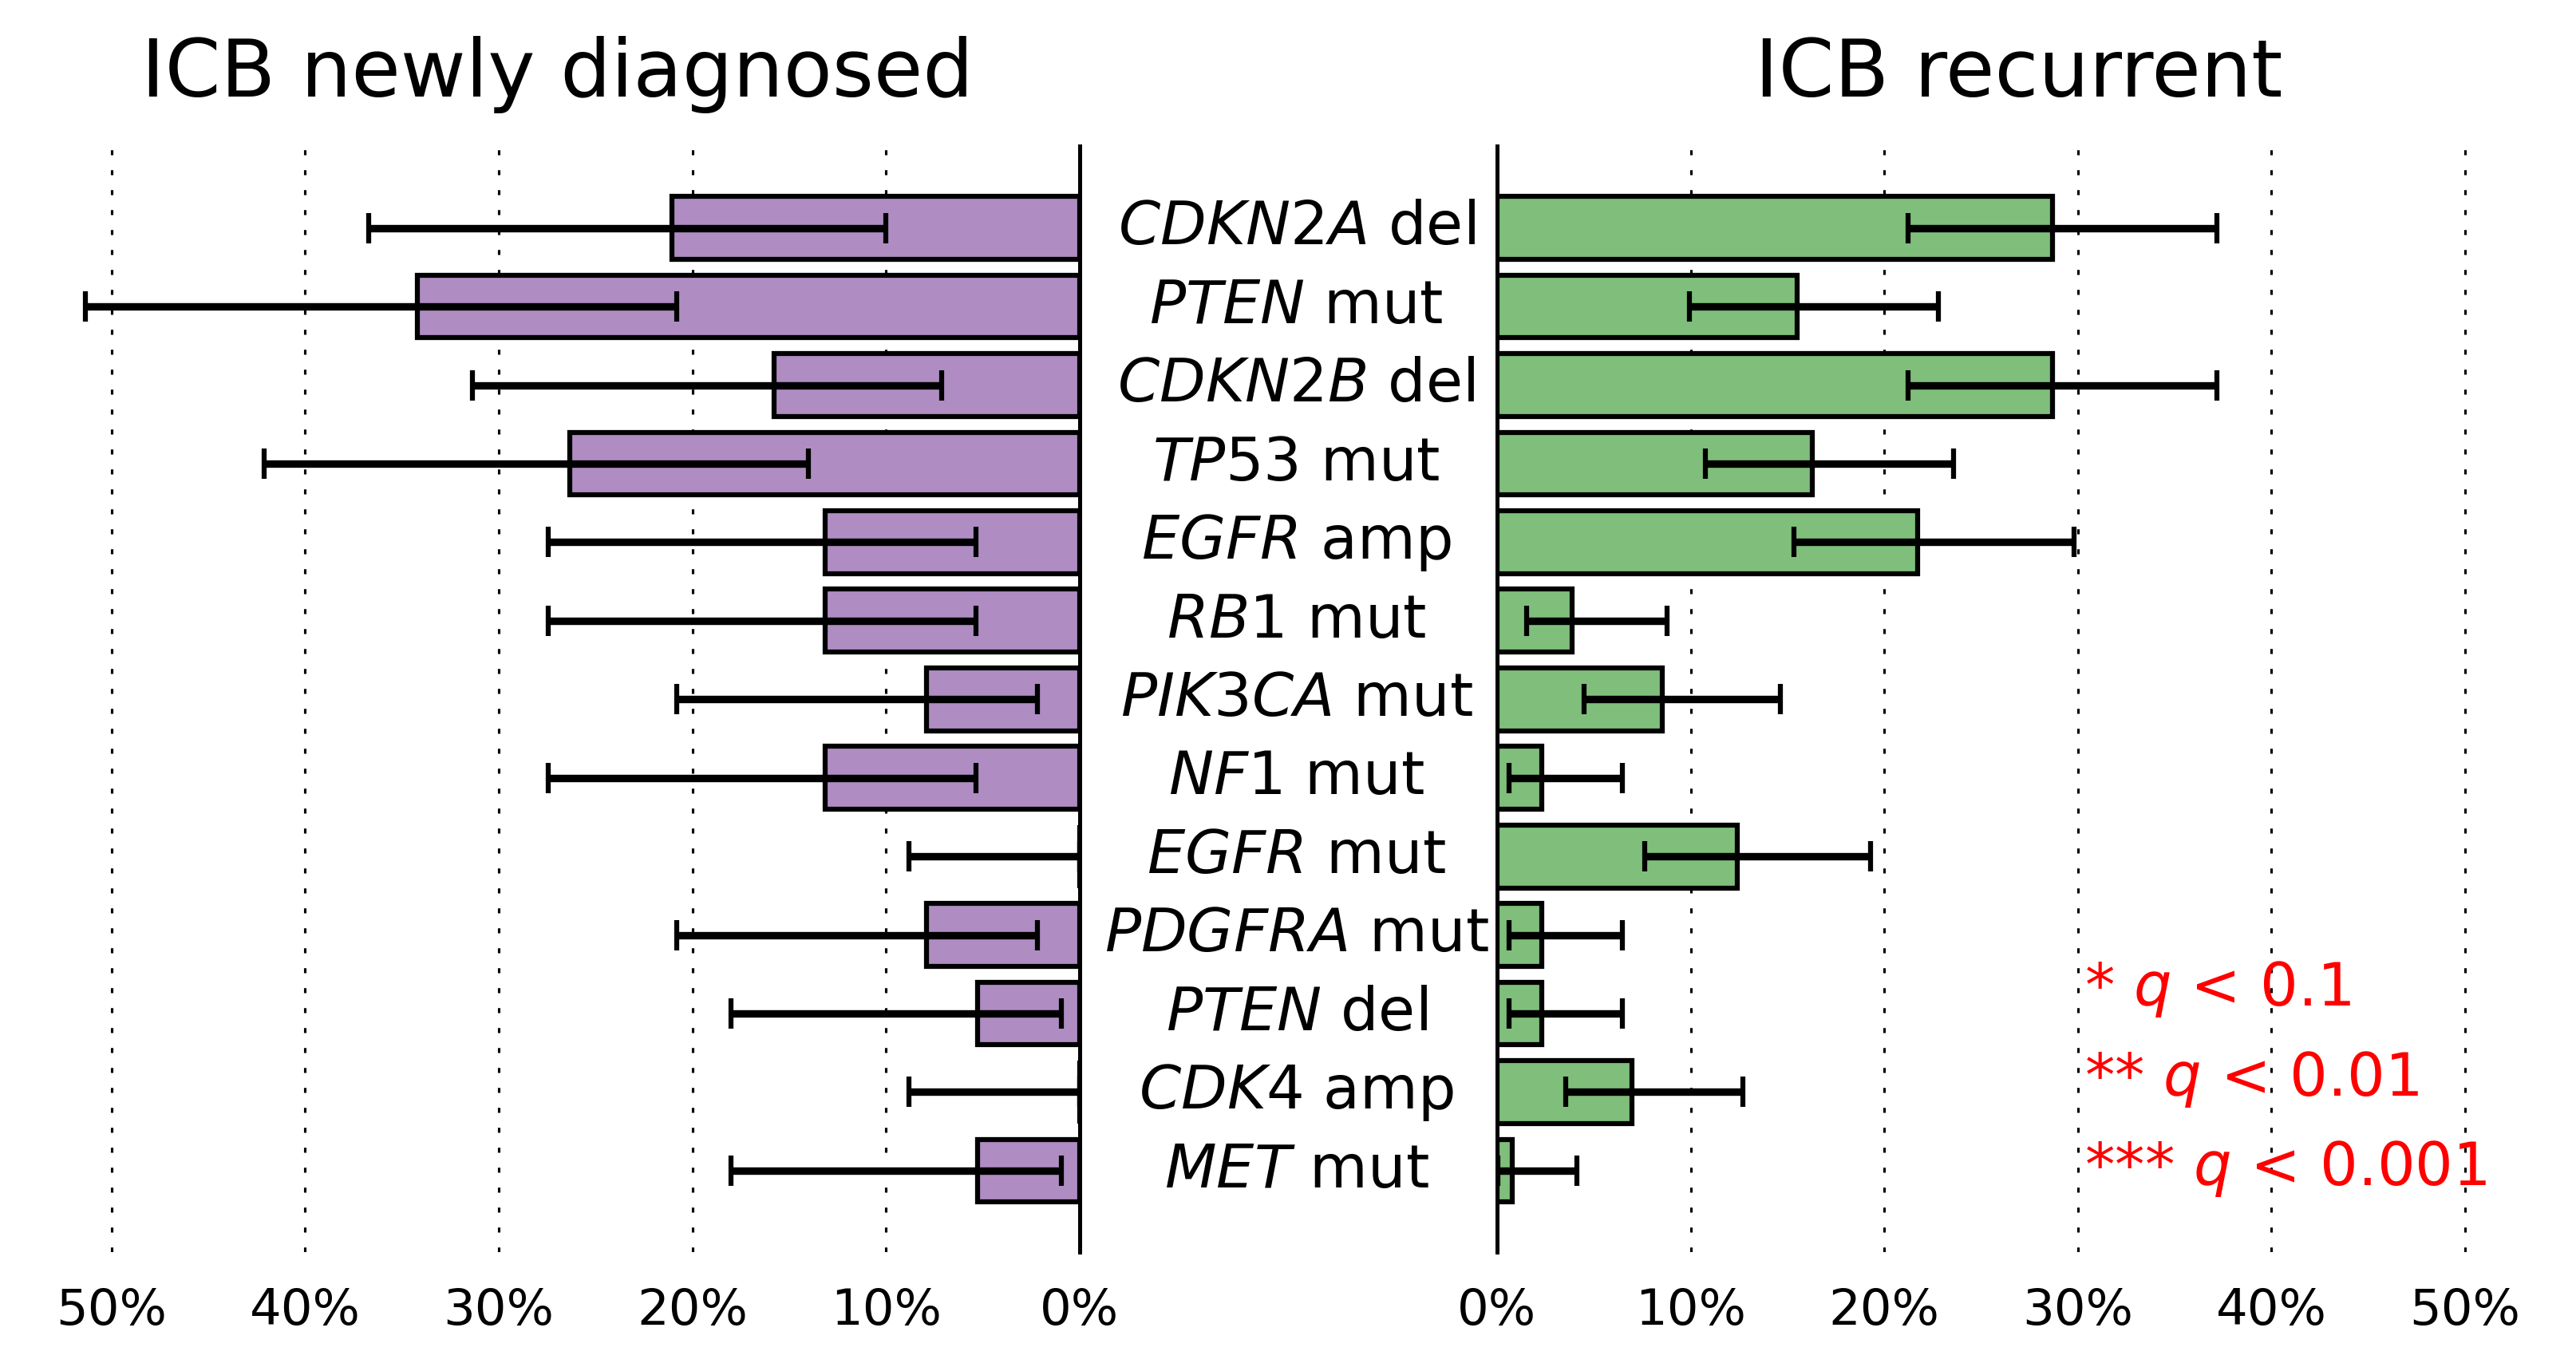

In [29]:
plot_df = tmp_df[['frac_mut_primary', 'frac_mut_recurrent', 'err_low_primary', 'err_high_primary', 'err_low_recurrent', 'err_high_recurrent']]\
    .rename(columns = {'frac_mut_primary': 'ICB newly diagnosed',
                       'frac_mut_recurrent': 'ICB recurrent'})

butterfly_chart(
    plot_df,
    tmp_df['p_adj'],
    left_color=cohort_color_mapping['ICB newly diagnosed'],
    right_color=cohort_color_mapping['ICB recurrent'],
    figsize=(9, 4),
    wspace=0.4,
    middle_label_offset=0.015,
    pdf_save_path=os.path.join('../data', 'butterfly_icb_newlydiagnosed_vs_recurrent.pdf'),
    png_save_path=os.path.join('../data', 'butterfly_icb_newlydiagnosed_vs_recurrent.png')
)

### GLASS primary vs. ICB newly diagnosed

In [30]:
tmp_df = pd.concat([icb_tidy[icb_tidy['primary_or_recurrent'] == 'primary'],
                    glass_tidy[glass_tidy['primary_or_recurrent'] == 'primary']],
                  ignore_index = True)

tmp_df = tmp_df.pivot(index = 'category',
                     columns = 'cohort',
                     values = ['n_pts_mut', 'n_pts_wt', 'frac_mut', 'err_low', 'err_high'])

tmp_df.columns = ['_'.join(c) for c in tmp_df.columns.values]

tmp_df = tmp_df[(tmp_df['frac_mut_ICB'] > 0) | (tmp_df['frac_mut_GLASS SoC'] > 0)]

for i, row in tmp_df.iterrows():
    res = fisher_exact([[row['n_pts_mut_GLASS SoC'], row['n_pts_wt_GLASS SoC']],
                        [row['n_pts_mut_ICB'], row['n_pts_wt_ICB']]],
                      alternative = 'two-sided')
    tmp_df.loc[i, 'fisher_p'] = res.pvalue
    
tmp_df['p_adj'] = multipletests(tmp_df['fisher_p'], method='fdr_bh')[1]

tmp_df['combined_freq'] = tmp_df['frac_mut_GLASS SoC'] + tmp_df['frac_mut_ICB']
tmp_df.sort_values('combined_freq', inplace = True)

tmp_df = tmp_df[(tmp_df['frac_mut_ICB'] > 0.05) | (tmp_df['frac_mut_GLASS SoC'] > 0.05)]

tmp_df.tail()

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,err_low_GLASS SoC,err_low_ICB,err_high_GLASS SoC,err_high_ICB,fisher_p,p_adj,combined_freq
category,,,,,,,,,,,,,
TP53 mut,42.0,10.0,111.0,28.0,0.274510,0.263158,0.065970,0.123142,0.078071,0.157799,1.000000,1.000000,0.537668
CDKN2B del,60.0,6.0,93.0,32.0,0.392157,0.157895,0.075560,0.086823,0.081637,0.155597,0.007201,0.134410,0.550052
EGFR amp,68.0,5.0,85.0,33.0,0.444444,0.131579,0.078740,0.078270,0.081762,0.142778,0.000315,0.017615,0.576023
CDKN2A del,58.0,8.0,95.0,30.0,0.379085,0.210526,0.075629,0.110587,0.081605,0.156658,0.057697,0.461572,0.589611
PTEN mut,49.0,13.0,104.0,25.0,0.320261,0.342105,0.069893,0.134137,0.078228,0.171221,0.847294,1.000000,0.662367


In [31]:
tmp_df["percent_change"] = (tmp_df["frac_mut_ICB"] / tmp_df["frac_mut_GLASS SoC"] - 1) * 100
tmp_df[tmp_df['p_adj'] < 0.1]

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,err_low_GLASS SoC,err_low_ICB,err_high_GLASS SoC,err_high_ICB,fisher_p,p_adj,combined_freq,percent_change
category,,,,,,,,,,,,,,
EGFR mut,30.0,0.0,123.0,38.0,0.196078,0.000000,0.05629,0.00000,0.071371,0.088199,0.000924,0.025860,0.196078,-100.000000
EGFR amp,68.0,5.0,85.0,33.0,0.444444,0.131579,0.07874,0.07827,0.081762,0.142778,0.000315,0.017615,0.576023,-70.394737


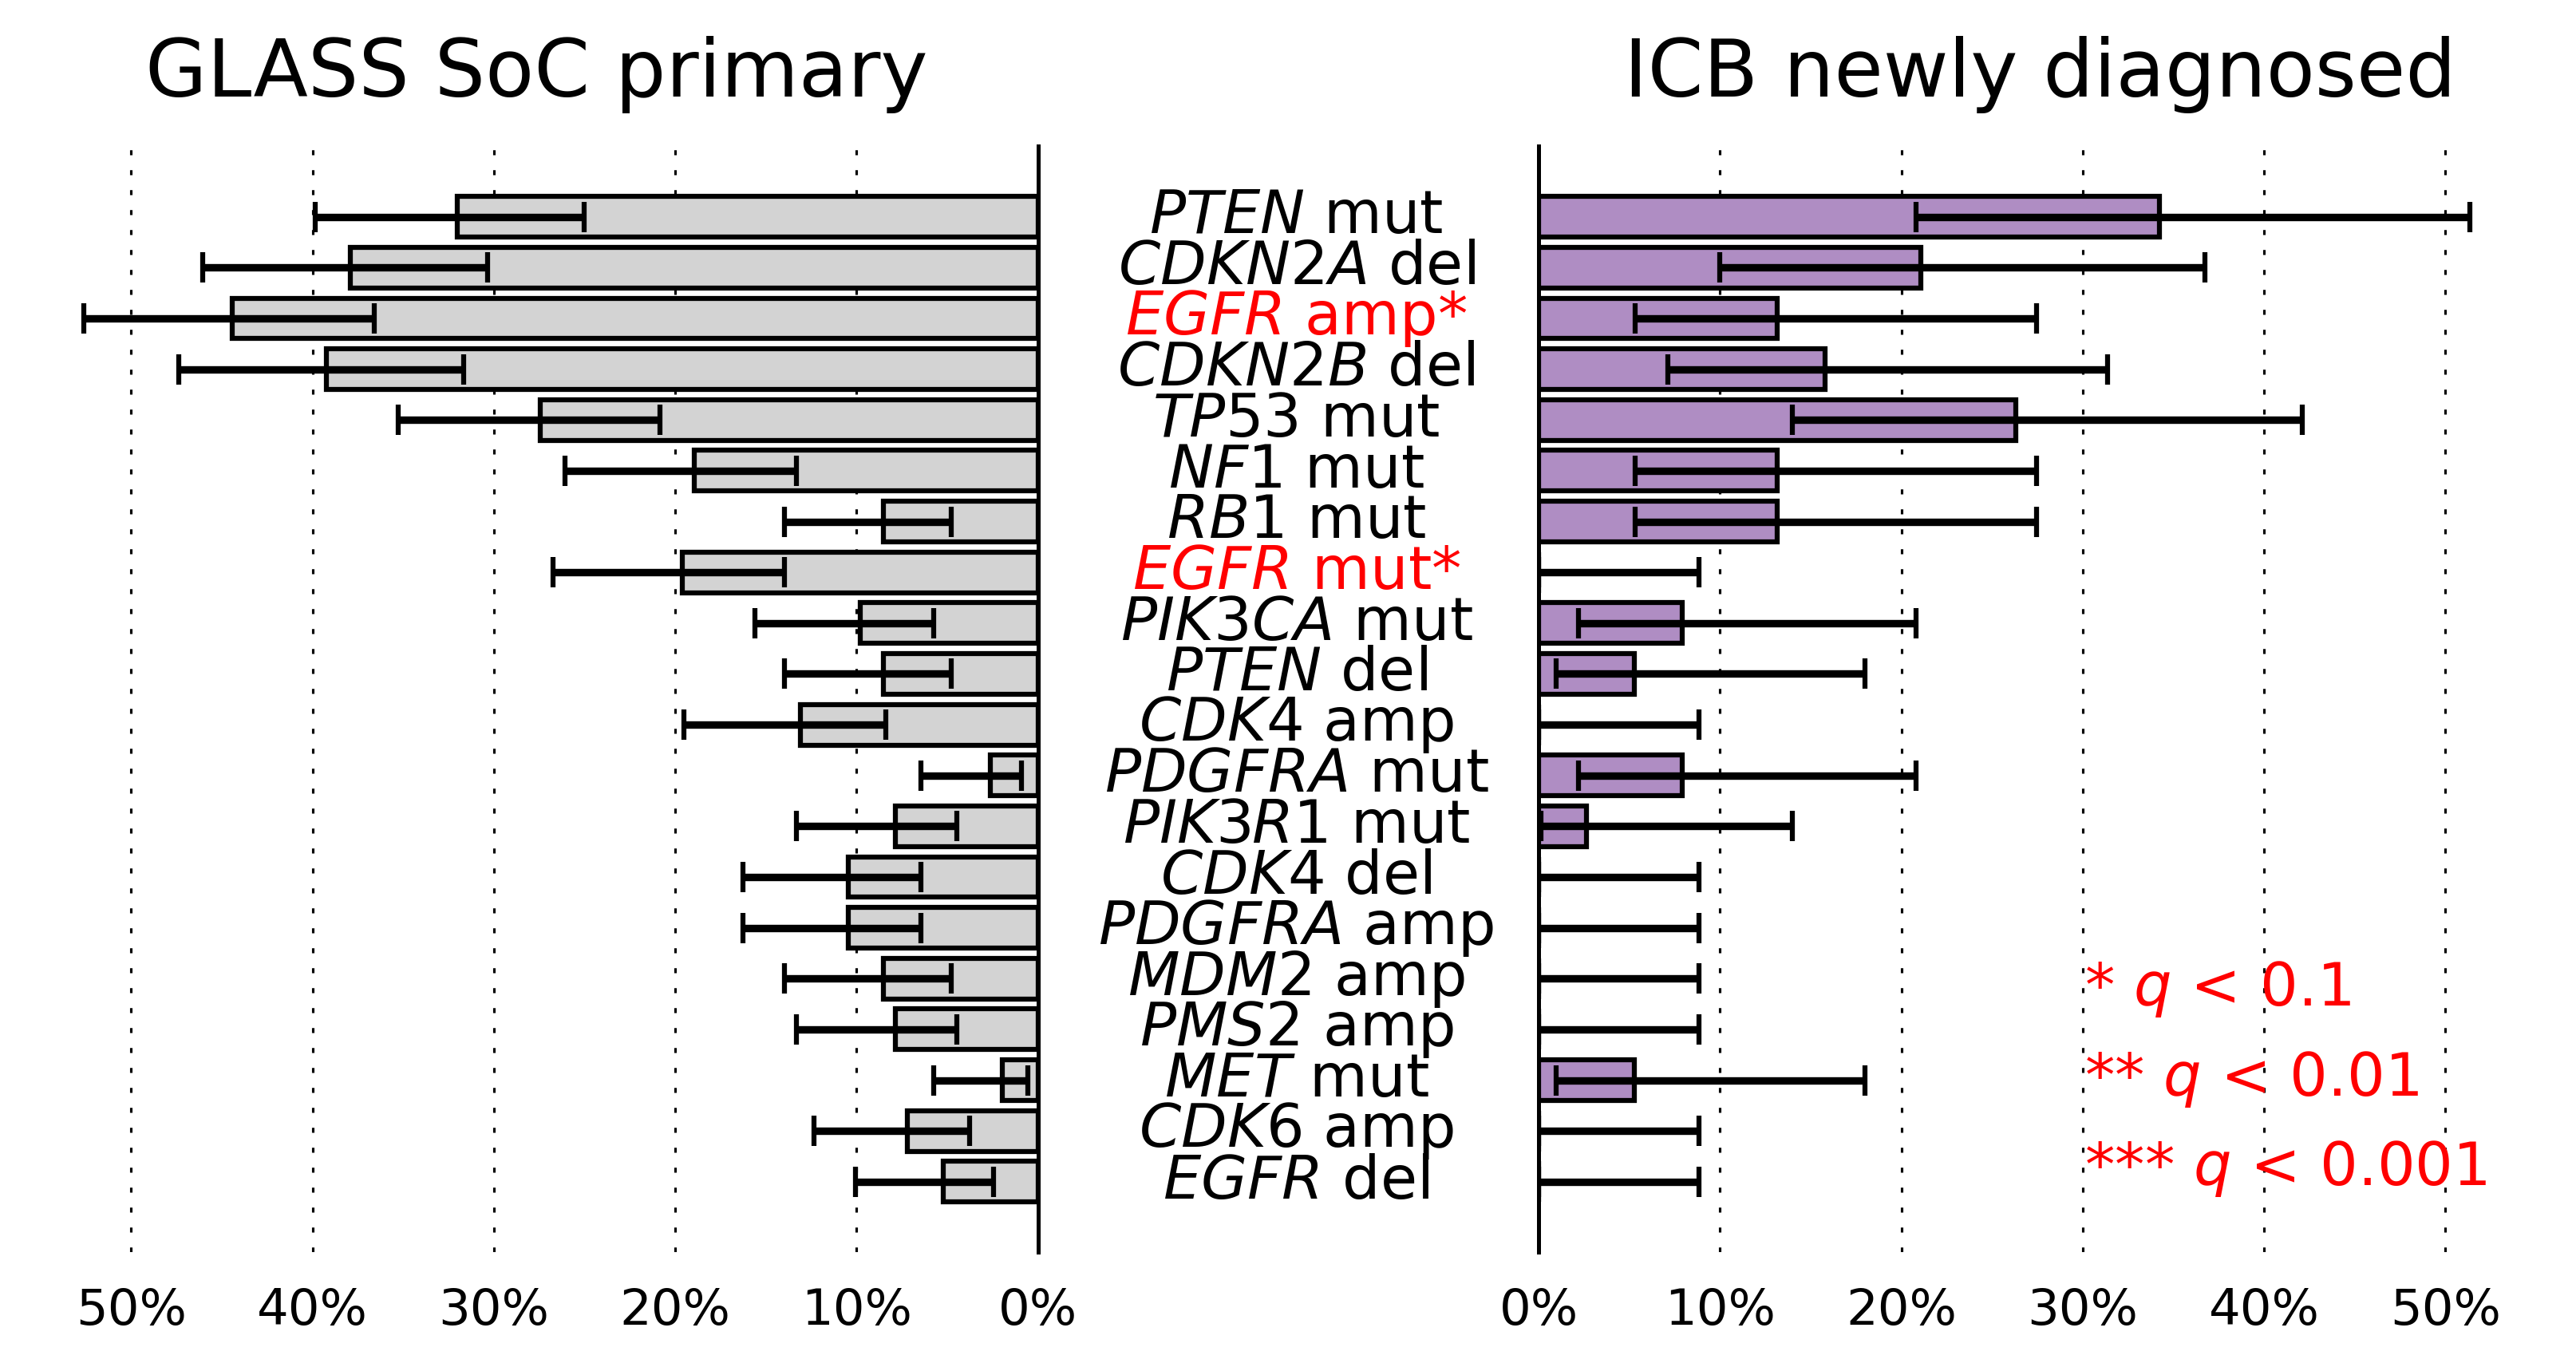

In [32]:
plot_df = tmp_df[['frac_mut_GLASS SoC', 'frac_mut_ICB', 'err_low_GLASS SoC', 'err_high_GLASS SoC', 'err_low_ICB', 'err_high_ICB']]\
    .rename(columns = {'frac_mut_GLASS SoC': 'GLASS SoC primary',
                       'frac_mut_ICB': 'ICB newly diagnosed'})

butterfly_chart(
    plot_df,
    tmp_df['p_adj'],
    left_color=cohort_color_mapping['GLASS SoC primary'],
    right_color=cohort_color_mapping['ICB newly diagnosed'],
    figsize=(9, 4),
    wspace=0.5,
    middle_label_offset=0.015,
    pdf_save_path=os.path.join('../data', 'butterfly_icb_newlydiagnosed_vs_glass_primary.pdf'),
    png_save_path=os.path.join('../data/', 'butterfly_icb_newlydiagnosed_vs_glass_primary.png')
)

### GLASS recurrent vs. ICB recurrent

In [33]:
tmp_df = pd.concat([icb_tidy[icb_tidy['primary_or_recurrent'] == 'recurrent'],
                    glass_tidy[glass_tidy['primary_or_recurrent'] == 'recurrent']],
                  ignore_index = True)

tmp_df = tmp_df.pivot(index = 'category',
                     columns = 'cohort',
                     values = ['n_pts_mut', 'n_pts_wt', 'frac_mut', 'err_low', 'err_high'])

tmp_df.columns = ['_'.join(c) for c in tmp_df.columns.values]

tmp_df = tmp_df[(tmp_df['frac_mut_ICB'] > 0) | (tmp_df['frac_mut_GLASS SoC'] > 0)]

for i, row in tmp_df.iterrows():
    res = fisher_exact([[row['n_pts_mut_GLASS SoC'], row['n_pts_wt_GLASS SoC']],
                        [row['n_pts_mut_ICB'], row['n_pts_wt_ICB']]],
                      alternative = 'two-sided')
    tmp_df.loc[i, 'fisher_p'] = res.pvalue
    
tmp_df['p_adj'] = multipletests(tmp_df['fisher_p'], method='fdr_bh')[1]

tmp_df['combined_freq'] = tmp_df['frac_mut_GLASS SoC'] + tmp_df['frac_mut_ICB']
tmp_df.sort_values('combined_freq', inplace = True)

tmp_df = tmp_df[(tmp_df['frac_mut_ICB'] > 0.05) | (tmp_df['frac_mut_GLASS SoC'] > 0.05)]

tmp_df.tail()

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,err_low_GLASS SoC,err_low_ICB,err_high_GLASS SoC,err_high_ICB,fisher_p,p_adj,combined_freq
category,,,,,,,,,,,,,
TP53 mut,46.0,21.0,125.0,108.0,0.269006,0.162791,0.061933,0.055255,0.072773,0.073042,0.035423,0.263746,0.431797
PTEN mut,54.0,20.0,117.0,109.0,0.315789,0.155039,0.067816,0.055581,0.073645,0.072958,0.001752,0.026714,0.470828
EGFR amp,55.0,28.0,116.0,101.0,0.321637,0.217054,0.067771,0.063909,0.075799,0.080829,0.050897,0.277204,0.538692
CDKN2B del,64.0,37.0,107.0,92.0,0.374269,0.286822,0.070550,0.074527,0.075927,0.084936,0.138563,0.384198,0.661091
CDKN2A del,65.0,37.0,106.0,92.0,0.380117,0.286822,0.070523,0.074527,0.075939,0.084936,0.109541,0.371221,0.666939


In [34]:
tmp_df["percent_change"] = (tmp_df["frac_mut_ICB"] / tmp_df["frac_mut_GLASS SoC"] - 1) * 100

In [35]:
tmp_df[tmp_df['p_adj'] < 0.6]

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,err_low_GLASS SoC,err_low_ICB,err_high_GLASS SoC,err_high_ICB,fisher_p,p_adj,combined_freq,percent_change
category,,,,,,,,,,,,,,
BRAF amp,9.0,0.0,162.0,129.0,0.052632,0.000000,0.026077,0.000000,0.045812,0.029126,0.011638,0.141987,0.052632,-100.000000
MSH6 mut,12.0,0.0,159.0,129.0,0.070175,0.000000,0.030276,0.000000,0.048935,0.029126,0.001532,0.026714,0.070175,-100.000000
CDK4 del,15.0,0.0,156.0,129.0,0.087719,0.000000,0.036294,0.000000,0.051964,0.029126,0.000211,0.006422,0.087719,-100.000000
PDGFRA amp,14.0,4.0,157.0,125.0,0.081871,0.031008,0.033207,0.020348,0.051845,0.045431,0.085649,0.307330,0.112879,-62.126246
RB1 mut,14.0,5.0,157.0,124.0,0.081871,0.038760,0.033207,0.023365,0.051845,0.049200,0.154938,0.393801,0.120631,-52.657807
MDM2 amp,14.0,5.0,157.0,124.0,0.081871,0.038760,0.033207,0.023365,0.051845,0.049200,0.154938,0.393801,0.120631,-52.657807
CDK4 amp,18.0,9.0,153.0,120.0,0.105263,0.069767,0.038874,0.034368,0.054941,0.057227,0.315557,0.570382,0.175031,-33.720930
NF1 mut,32.0,3.0,139.0,126.0,0.187135,0.023256,0.053418,0.016888,0.066732,0.041619,0.000006,0.000338,0.210390,-87.572674
EGFR mut,38.0,16.0,133.0,113.0,0.222222,0.124031,0.057098,0.047592,0.069741,0.068945,0.033453,0.263746,0.346253,-44.186047


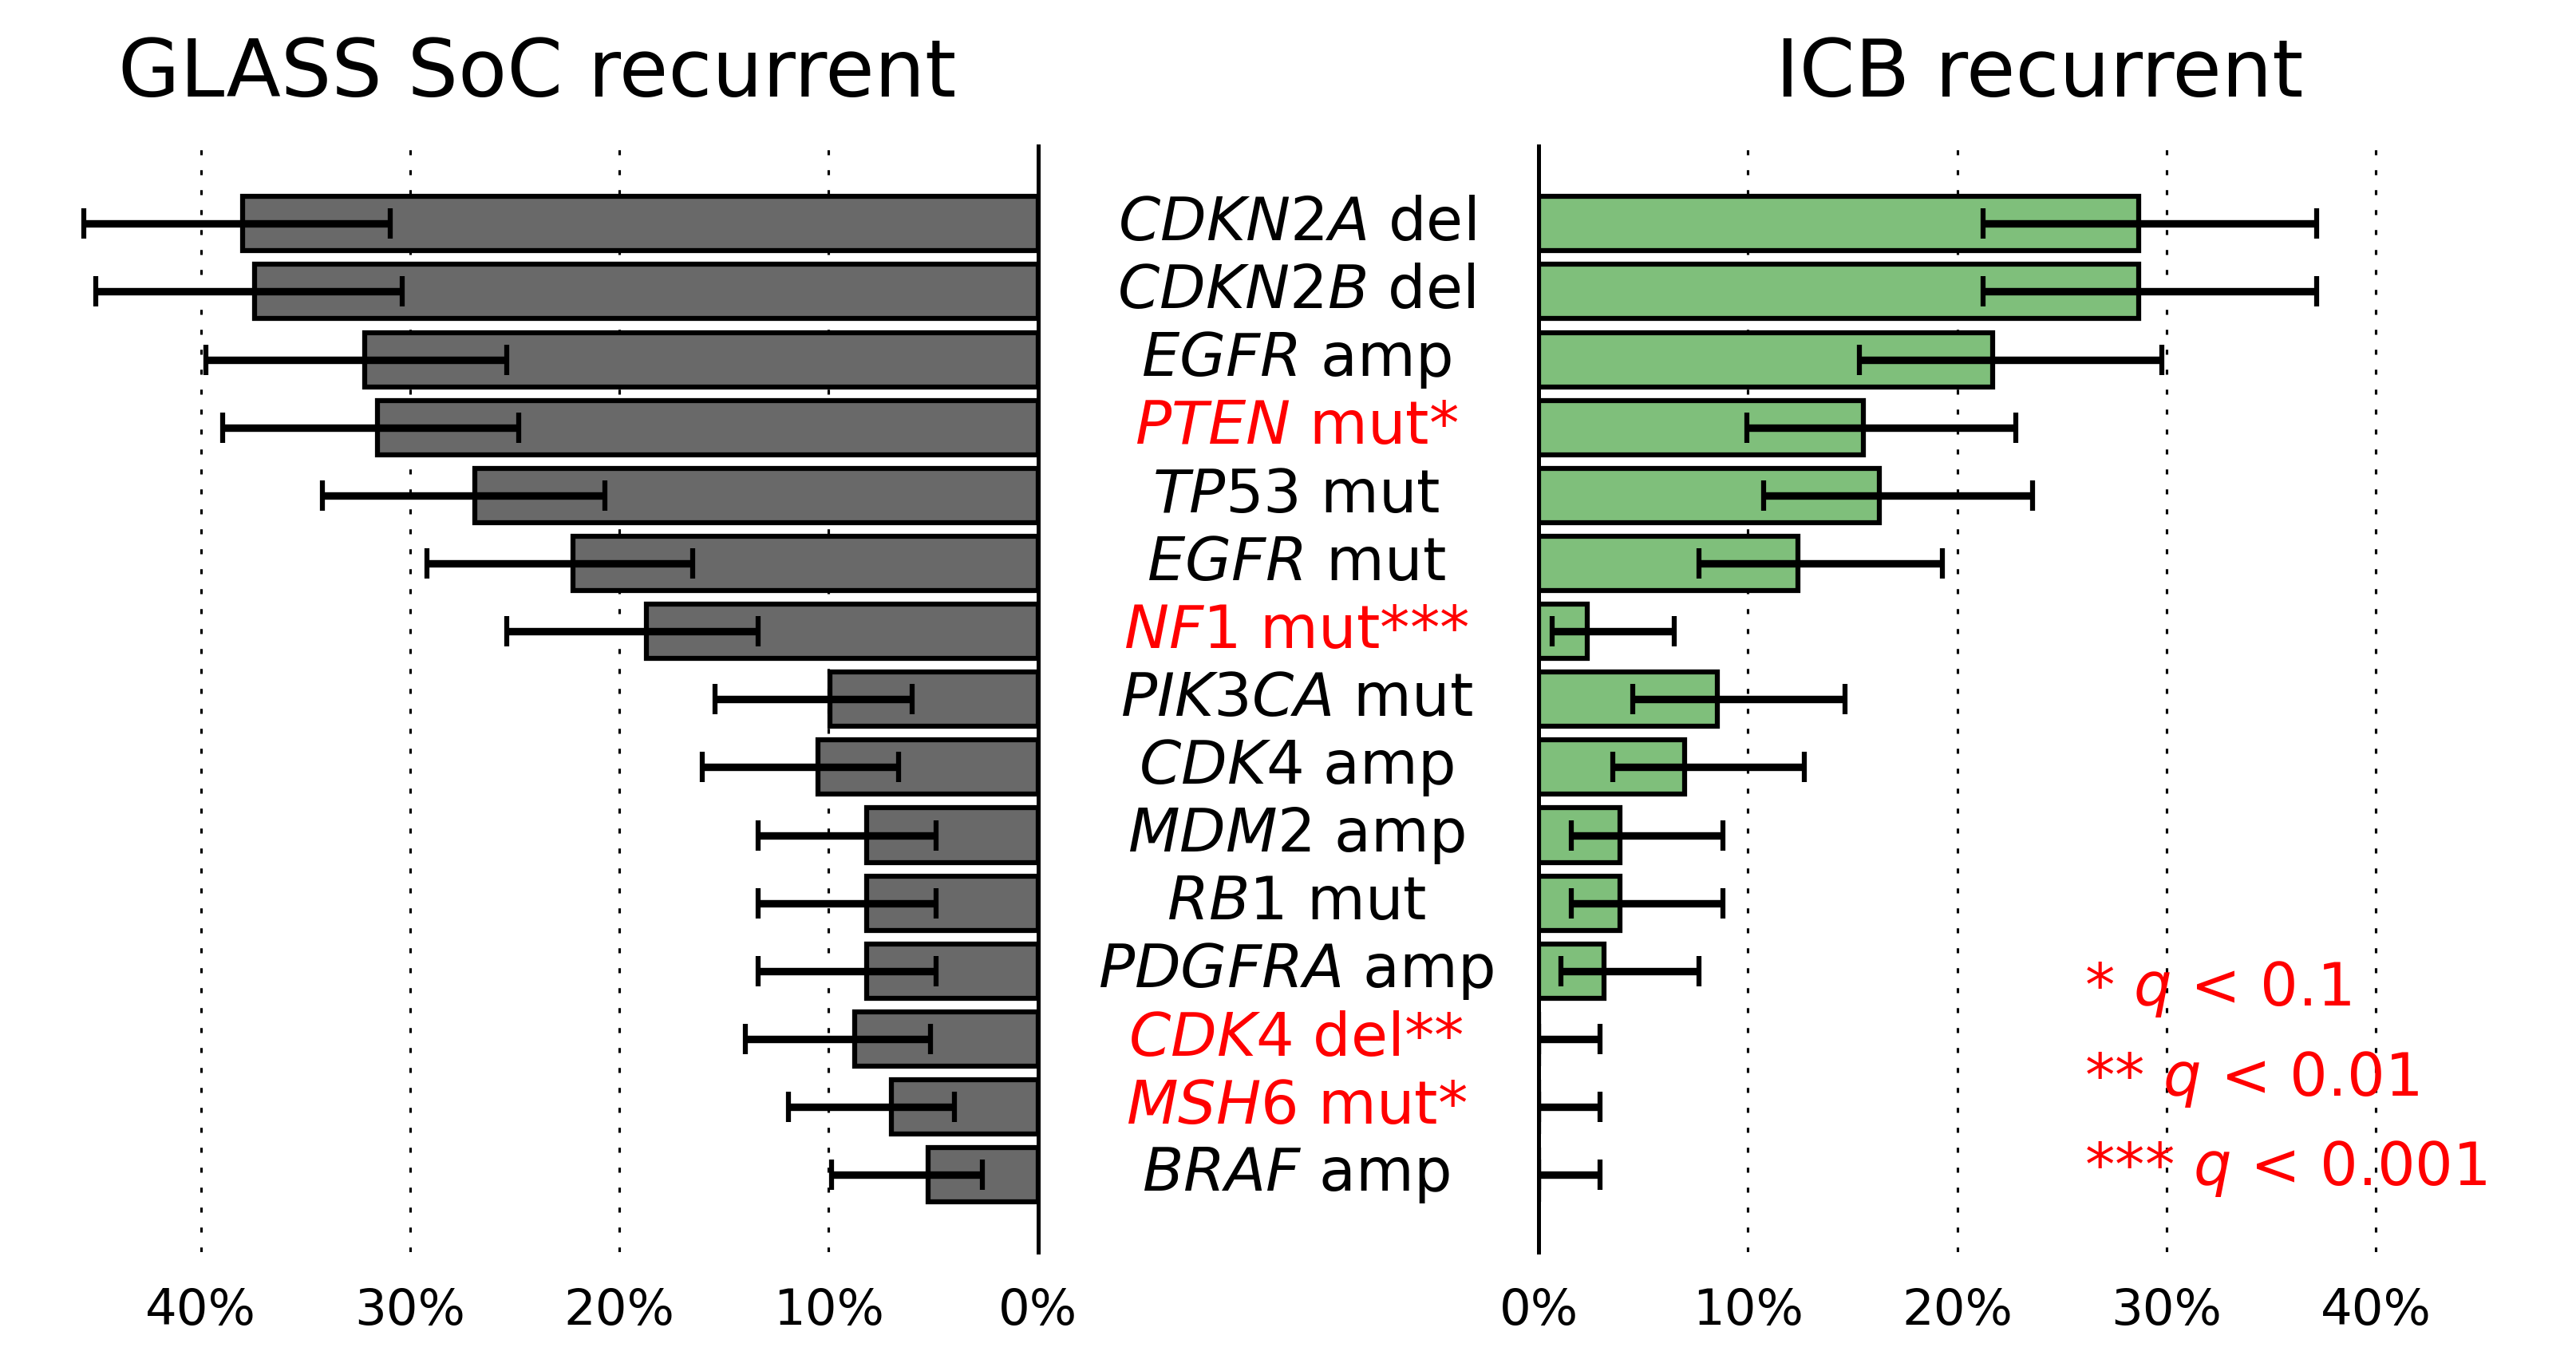

In [36]:
plot_df = tmp_df[['frac_mut_GLASS SoC', 'frac_mut_ICB', 'err_low_GLASS SoC', 'err_high_GLASS SoC', 'err_low_ICB', 'err_high_ICB']]\
    .rename(columns = {'frac_mut_GLASS SoC': 'GLASS SoC recurrent',
                       'frac_mut_ICB': 'ICB recurrent'})

butterfly_chart(
    plot_df,
    tmp_df['p_adj'],
    left_color=cohort_color_mapping['GLASS SoC recurrent'],
    right_color=cohort_color_mapping['ICB recurrent'],
    figsize=(9, 4),
    wspace=0.5,
    middle_label_offset=0.015,
    pdf_save_path=os.path.join('../data', 'butterfly_icb_recurrent_vs_glass_recurrent.pdf'),
    png_save_path=os.path.join('../data', 'butterfly_icb_recurrent_vs_glass_recurrent.png')
)

### GLASS combined vs. ICB combined

In [37]:
# First, regenerate the tidy dataframes without splitting by primary/recurrent
glass_tidy = glass_variants[['Sample_ID', 'category']].drop_duplicates()

glass_tidy.rename(columns = {'Sample_ID': 'sample'}, inplace = True)

glass_tidy = glass_tidy.groupby(['category'])['sample']\
    .nunique()\
    .reindex(alteration_list, fill_value = 0.0)\
    .reset_index()\
    .rename(columns = {'sample': 'n_pts_mut'})

glass_tidy['n_pts_total'] = len(glass_p_samples) + len(glass_r_samples)
glass_tidy['n_pts_wt'] = glass_tidy['n_pts_total'] - glass_tidy['n_pts_mut']
glass_tidy['frac_mut'] = glass_tidy['n_pts_mut'].div(glass_tidy['n_pts_total'])
glass_tidy['cohort'] = 'GLASS SoC'
glass_tidy = glass_tidy[glass_tidy['category'] != 'TERT mut']

icb_tidy = icb_variants[['sample', 'category']].drop_duplicates()

icb_tidy = icb_tidy.groupby(['category'])['sample']\
    .nunique()\
    .reindex(alteration_list, fill_value = 0.0)\
    .reset_index()\
    .rename(columns = {'sample': 'n_pts_mut'})

icb_tidy['n_pts_total'] = len(icb_nd_pts) + len(icb_r_pts)
icb_tidy['n_pts_wt'] = icb_tidy['n_pts_total'] - icb_tidy['n_pts_mut']
icb_tidy['frac_mut'] = icb_tidy['n_pts_mut'].div(icb_tidy['n_pts_total'])
icb_tidy['cohort'] = 'ICB'
icb_tidy = icb_tidy[icb_tidy['category'] != 'TERT mut']

tmp_df = pd.concat([icb_tidy,
                    glass_tidy],
                  ignore_index = True)

tmp_df = tmp_df.pivot(index = 'category',
                     columns = 'cohort',
                     values = ['n_pts_mut', 'n_pts_wt', 'frac_mut'])

tmp_df.columns = ['_'.join(c) for c in tmp_df.columns.values]

tmp_df = tmp_df[(tmp_df['frac_mut_ICB'] > 0) | (tmp_df['frac_mut_GLASS SoC'] > 0)]

for i, row in tmp_df.iterrows():
    res = fisher_exact([[row['n_pts_mut_GLASS SoC'], row['n_pts_wt_GLASS SoC']],
                        [row['n_pts_mut_ICB'], row['n_pts_wt_ICB']]],
                      alternative = 'two-sided')
    tmp_df.loc[i, 'fisher_p'] = res.pvalue

tmp_df['p_adj'] = multipletests(tmp_df['fisher_p'], method='fdr_bh')[1]

tmp_df['combined_freq'] = tmp_df['frac_mut_GLASS SoC'] + tmp_df['frac_mut_ICB']
tmp_df.sort_values('combined_freq', inplace = True)

tmp_df = tmp_df[(tmp_df['frac_mut_ICB'] > 0.05) | (tmp_df['frac_mut_GLASS SoC'] > 0.05)]

tmp_df.tail()

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,fisher_p,p_adj,combined_freq
category,,,,,,,,,
TP53 mut,88.0,31.0,236.0,136.0,0.271605,0.185629,0.035412,0.154929,0.457234
PTEN mut,103.0,33.0,221.0,134.0,0.317901,0.197605,0.005529,0.045563,0.515506
EGFR amp,123.0,33.0,201.0,134.0,0.379630,0.197605,0.000039,0.000908,0.577234
CDKN2B del,124.0,43.0,200.0,124.0,0.382716,0.257485,0.006537,0.045757,0.640201
CDKN2A del,123.0,45.0,201.0,122.0,0.379630,0.269461,0.016013,0.093411,0.649091


In [38]:
tmp_df["percent_change"] = (tmp_df["frac_mut_ICB"] / tmp_df["frac_mut_GLASS SoC"] - 1) * 100
tmp_df[tmp_df['fisher_p'] < 0.05]

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,fisher_p,p_adj,combined_freq,percent_change
category,,,,,,,,,,
PMS2 amp,17.0,0.0,307.0,167.0,0.052469,0.000000,0.001077,0.018846,0.052469,-100.000000
CDK6 amp,17.0,1.0,307.0,166.0,0.052469,0.005988,0.009214,0.058632,0.058457,-88.587531
CDK4 del,31.0,0.0,293.0,167.0,0.095679,0.000000,0.000002,0.000134,0.095679,-100.000000
MDM2 amp,27.0,5.0,297.0,162.0,0.083333,0.029940,0.031981,0.149247,0.113273,-64.071856
PDGFRA amp,30.0,4.0,294.0,163.0,0.092593,0.023952,0.004235,0.042345,0.116545,-74.131737
CDK4 amp,38.0,9.0,286.0,158.0,0.117284,0.053892,0.023680,0.118398,0.171176,-54.049795
NF1 mut,61.0,8.0,263.0,159.0,0.188272,0.047904,0.000008,0.000290,0.236176,-74.555806
EGFR mut,68.0,16.0,256.0,151.0,0.209877,0.095808,0.001454,0.020359,0.305685,-54.350123
TP53 mut,88.0,31.0,236.0,136.0,0.271605,0.185629,0.035412,0.154929,0.457234,-31.654872


In [39]:
tmp_df["fold_change"] = tmp_df["frac_mut_ICB"] / tmp_df["frac_mut_GLASS SoC"]

tmp_df

,n_pts_mut_GLASS SoC,n_pts_mut_ICB,n_pts_wt_GLASS SoC,n_pts_wt_ICB,frac_mut_GLASS SoC,frac_mut_ICB,fisher_p,p_adj,combined_freq,percent_change,fold_change
category,,,,,,,,,,,
PMS2 amp,17.0,0.0,307.0,167.0,0.052469,0.000000,0.001077,0.018846,0.052469,-100.000000,0.000000
CDK6 amp,17.0,1.0,307.0,166.0,0.052469,0.005988,0.009214,0.058632,0.058457,-88.587531,0.114125
PTEN del,20.0,5.0,304.0,162.0,0.061728,0.029940,0.192112,0.417169,0.091669,-51.497006,0.485030
CDK4 del,31.0,0.0,293.0,167.0,0.095679,0.000000,0.000002,0.000134,0.095679,-100.000000,0.000000
PIK3R1 mut,19.0,7.0,305.0,160.0,0.058642,0.041916,0.526664,0.822834,0.100558,-28.521904,0.714781
MDM2 amp,27.0,5.0,297.0,162.0,0.083333,0.029940,0.031981,0.149247,0.113273,-64.071856,0.359281
PDGFRA amp,30.0,4.0,294.0,163.0,0.092593,0.023952,0.004235,0.042345,0.116545,-74.131737,0.258683
RB1 mut,27.0,10.0,297.0,157.0,0.083333,0.059880,0.470553,0.822834,0.143214,-28.143713,0.718563
CDK4 amp,38.0,9.0,286.0,158.0,0.117284,0.053892,0.023680,0.118398,0.171176,-54.049795,0.459502
